# Scanning SQUID microscopy

One of the original motivations for `SuperScreen` was to model scanning superconducting quantum interference device (SQUID) magnetometers/susceptometers used in [scanning SQUID microscopy](https://en.wikipedia.org/wiki/Scanning_SQUID_microscopy). In this notebook we demonstrate how `SuperScreen` can be used to calculate the mutual inductance between the field coil and pickup loop in state-of-the-art scanning SQUID susceptometers ([Rev. Sci. Instrum. 87, 093702 (2016)](https://pubs.aip.org/aip/rsi/article/87/9/093702/365810/Scanning-SQUID-susceptometers-with-sub-micron), [arXiv:1605.09483](https://arxiv.org/abs/1605.09483)).

The layouts for four designs of scannning SQUID susceptometer are shown below (taken from Figure 4 of [Kirtley, et al., *Scanning SQUID susceptometers with sub-micron spatial resolution*, Rev. Sci. Instrum. 87, 093702 (2016)](https://pubs.aip.org/aip/rsi/article/87/9/093702/365810/Scanning-SQUID-susceptometers-with-sub-micron)). 

<img width="600px" align="center" src="../images/fig-4-squid-layouts.png">

There are three relevant superconducting wiring layers, labeled "BE" (blue), "W1" (purple), and "W2" (red). The **pickup loop**, the flux-sennsing loop that is part of the SQUID circuit, sits in the purple "W1" wiring layer. The pickup loop is partially covered by a superconducting shield in the red "W2" wiring layer, which sits between the pickup loop and the sample being measured. A single-turn **field coil** sitting in the blue "BE" wiring layer can be used to locally apply a magnetic field to the sample. The layer structure of the SQUID susceptometers is shown below (taken from Figure 5 of [Kirtley, et al., *Scanning SQUID susceptometers with sub-micron spatial resolution*, Rev. Sci. Instrum. 87, 093702 (2016)](https://pubs.aip.org/aip/rsi/article/87/9/093702/365810/Scanning-SQUID-susceptometers-with-sub-micron)).

<img width="400px" align="center" src="../images/fig-5-squid-layers.png">

The **pickup loop** and **field coil** can be used to perform a mutual inductance AC susceptibility measurement in a reflection geometry. The presence of a paramagnetic or diamagnetic sample near the pickup loop and field coil modifies the mutual inductance between the two loops, and the strength of the modification is a measure of the magnetic susceptibility of the sample. Quantitative modeling of the magnetic response of such multi-layer superconducting circuits is important both for interpreting measurements and for designing next-generation sensors.

The experimentally measured values of the pickup loop - field coil mutual inductance (in units of $\Phi_0/\mathrm{A}$, the flux induced in the pickup loop per unit current flowing in the field coil) are shown below. The value are taken from Table 1 of [Rev. Sci. Instrum. 87, 093702 (2016)](https://pubs.aip.org/aip/rsi/article/87/9/093702/365810/Scanning-SQUID-susceptometers-with-sub-micron). As shown below, we find excellent agreement between `SuperScreen` models derived from the as-designed SQUID layouts and the experimentally measured mutual inductance.

In [1]:
exp_mutuals = {
    "small": (69, 7),  # panel (a) in the first figure
    "medium": (166, 4),  # panel (b)
    "large": (594, 24),  # panel (c)
    "xlarge": (1598, 47),  # panel (d)
}

In [2]:
%config InlineBackend.figure_formats = {"retina", "png"}
%matplotlib inline

import os
import sys

os.environ["OPENBLAS_NUM_THREADS"] = "1"

import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.rcParams["figure.figsize"] = (5, 4)
plt.rcParams["font.size"] = 10

import superscreen as sc
from superscreen.geometry import box

sys.path.insert(0, "..")
import squids

## Define and solve the models

In [3]:
squid_funcs = {
    "small": squids.ibm.small.make_squid,
    "medium": squids.ibm.medium.make_squid,
    "large": squids.ibm.large.make_squid,
    "xlarge": squids.ibm.xlarge.make_squid,
}
mesh_kwargs = {
    "small": dict(max_edge_length=0.1, smooth=100),
    "medium": dict(max_edge_length=0.1, smooth=100),
    "large": dict(max_edge_length=0.15, smooth=100),
    "xlarge": dict(max_edge_length=0.4, smooth=100),
}

Here, we simulate the reponse of the four SQUID susceptometers to a fixed current of 1 mA flowing counterclockwise in the field coil.

In [4]:
solutions = {}
I_fc = "1 mA"
for name, make_squid in squid_funcs.items():
    squid = make_squid()
    squid.make_mesh(**mesh_kwargs[name])
    solutions[name] = sc.solve(
        squid,
        terminal_currents={"fc": {"source": I_fc, "drain": f"-{I_fc}"}},
        iterations=5,
    )[-1]
    clear_output()

## Evaluate the pickup loop - field coil mutual inductance

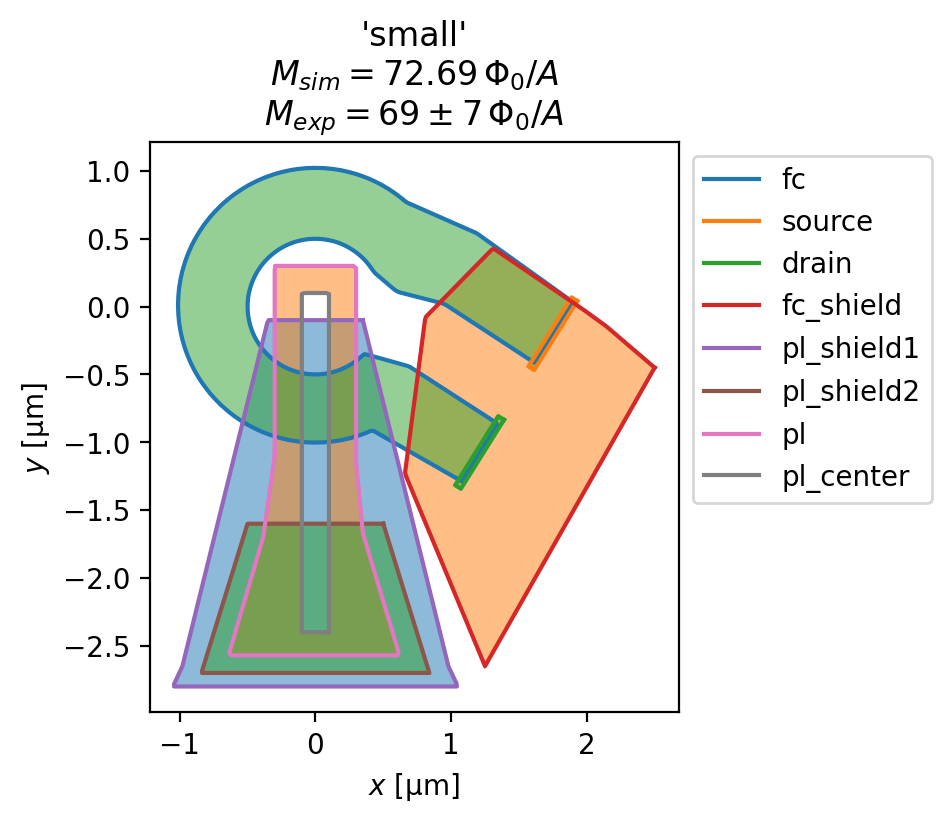

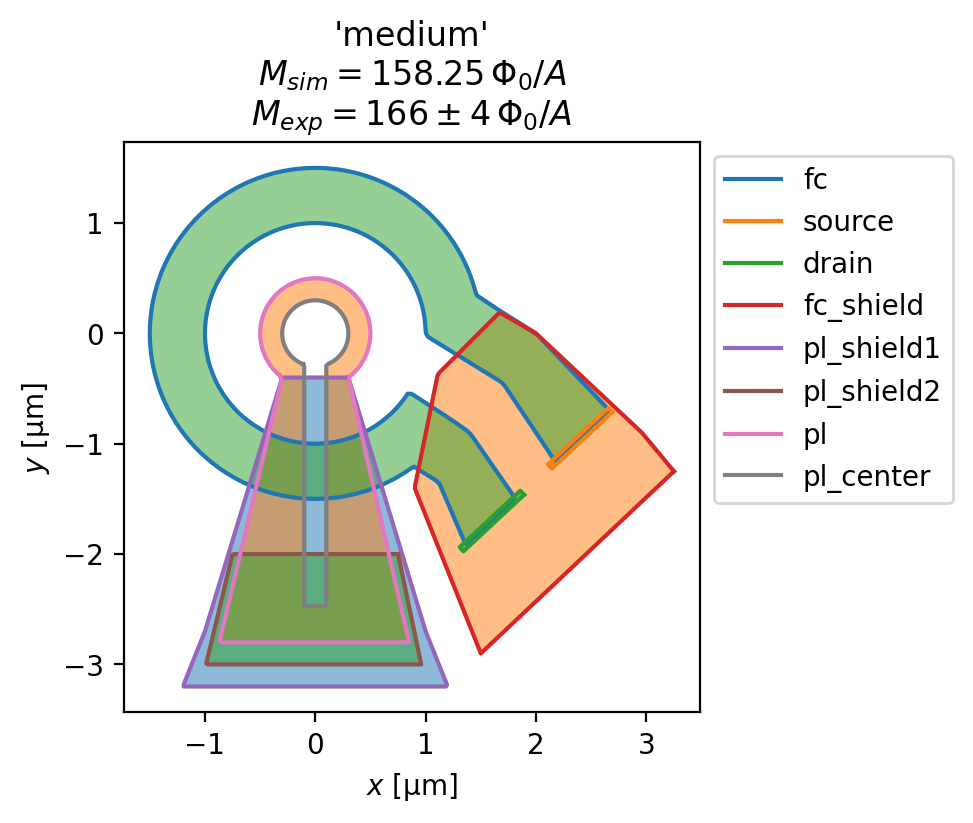

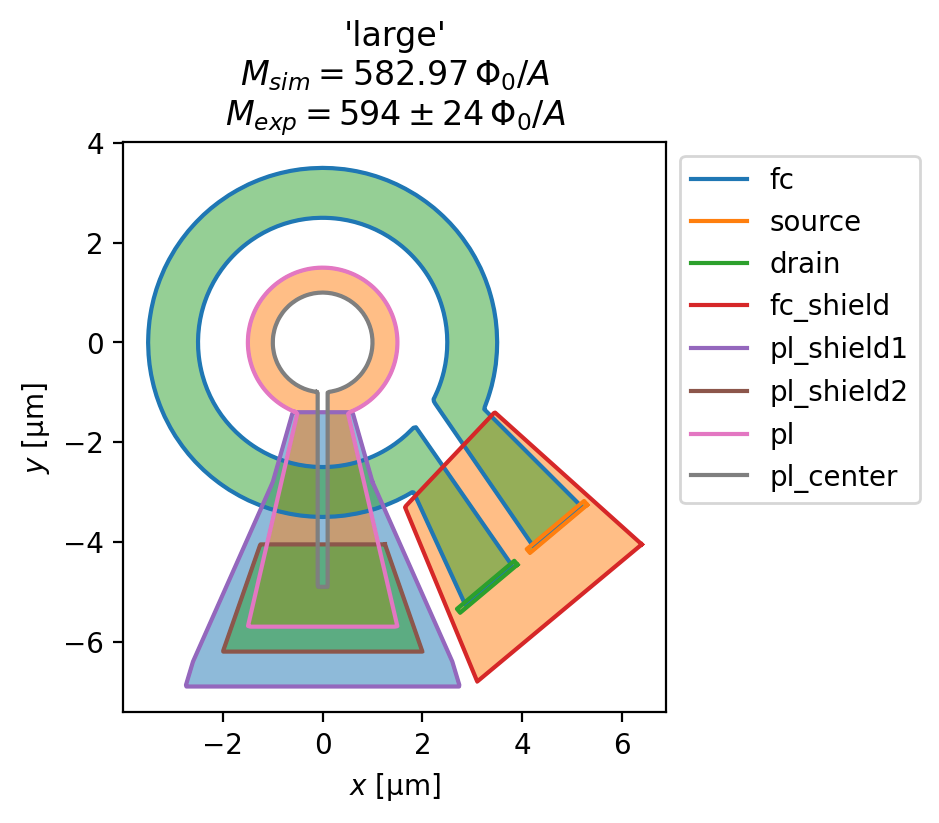

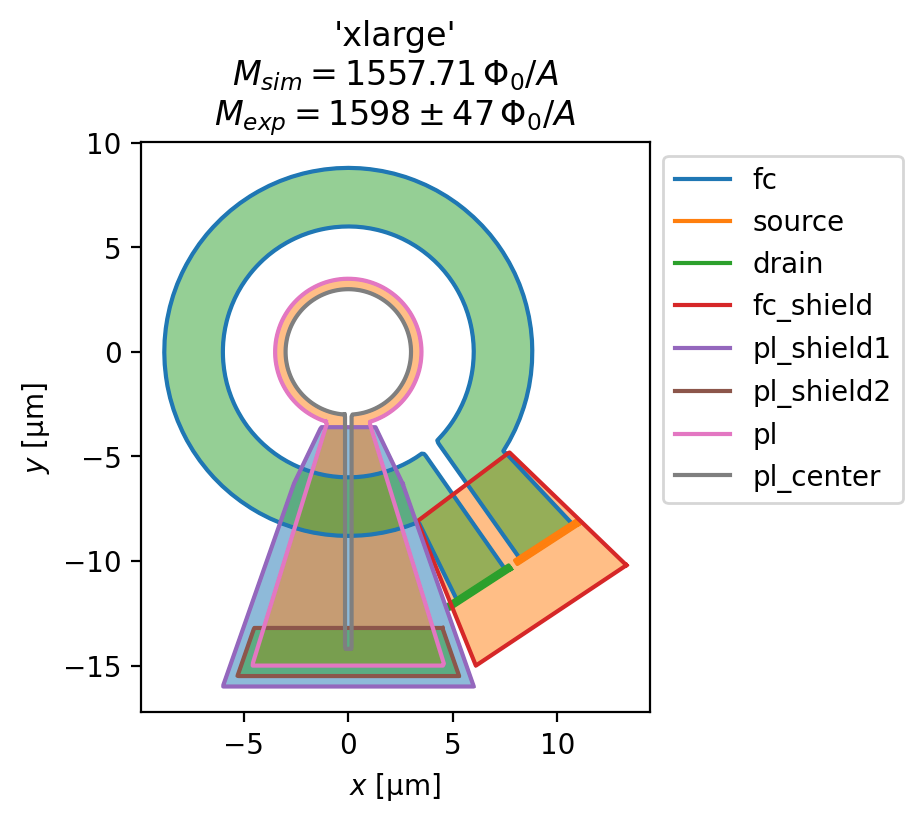

In [5]:
for name, solution in solutions.items():
    squid = solution.device
    fig, ax = squid.draw()
    _ = squid.plot_polygons(ax=ax, legend=True)
    
    fluxoid = sum(solution.hole_fluxoid("pl_center"))
    mutual_inductance = (fluxoid / sc.ureg(I_fc)).to("Phi_0 / A").magnitude
    mean, rng = exp_mutuals[name]
    title = [
        f"{name!r}",
        rf"$M_{{sim}}={{{mutual_inductance:.2f}}}\,\Phi_0/A$",
        rf"$M_{{exp}}={{{mean}}}\pm{{{rng}}}\,\Phi_0/A$"
    ]
    ax.set_title("\n".join(title))

## Evaluate the magnetic field generated by the susceptometer

Below, we plot the $z$-component of the magnetic field generated by the SQUID susceptometer field coil, evaluated at a plane 0.5 $\mu$m from the top wiring layer of the susceptometer.

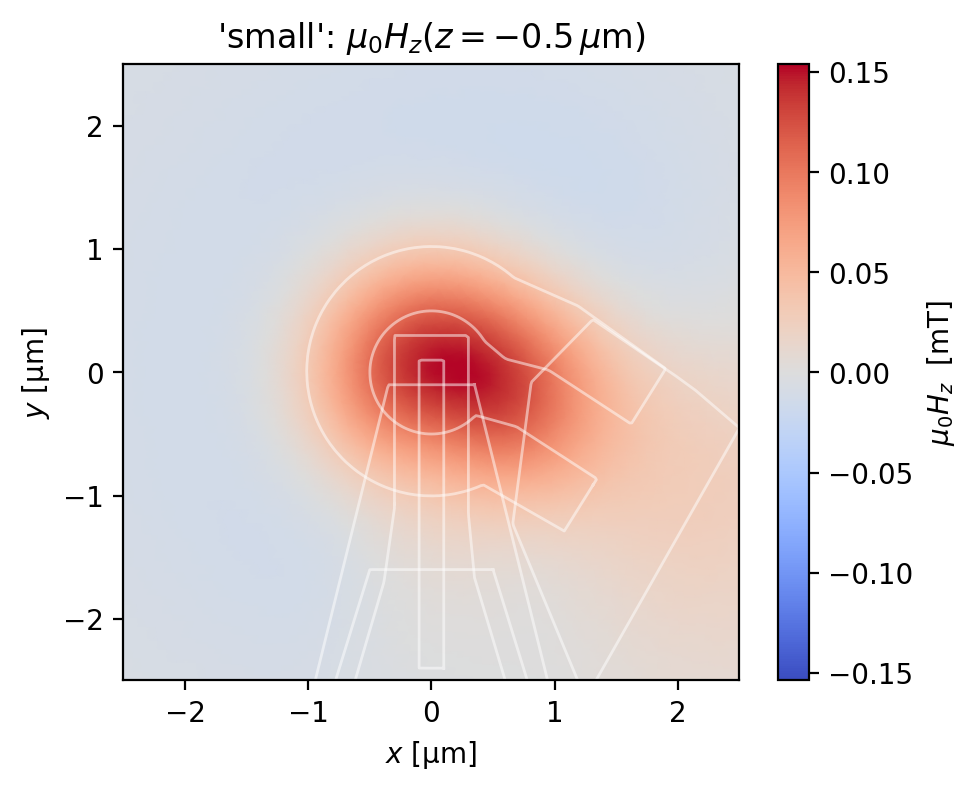

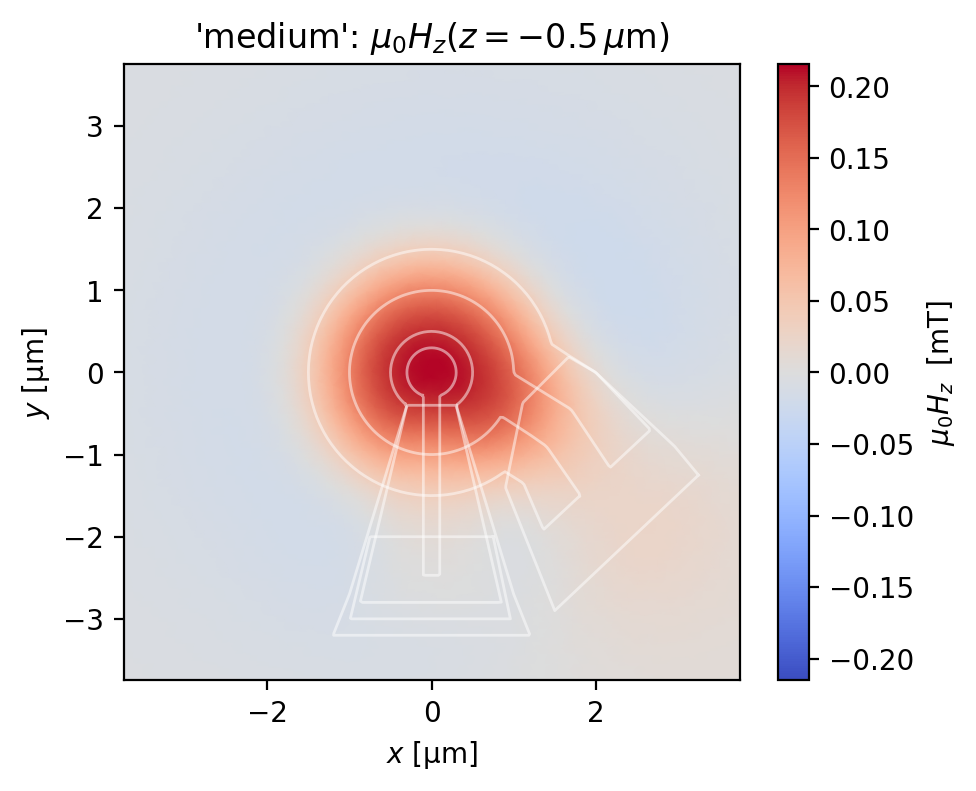

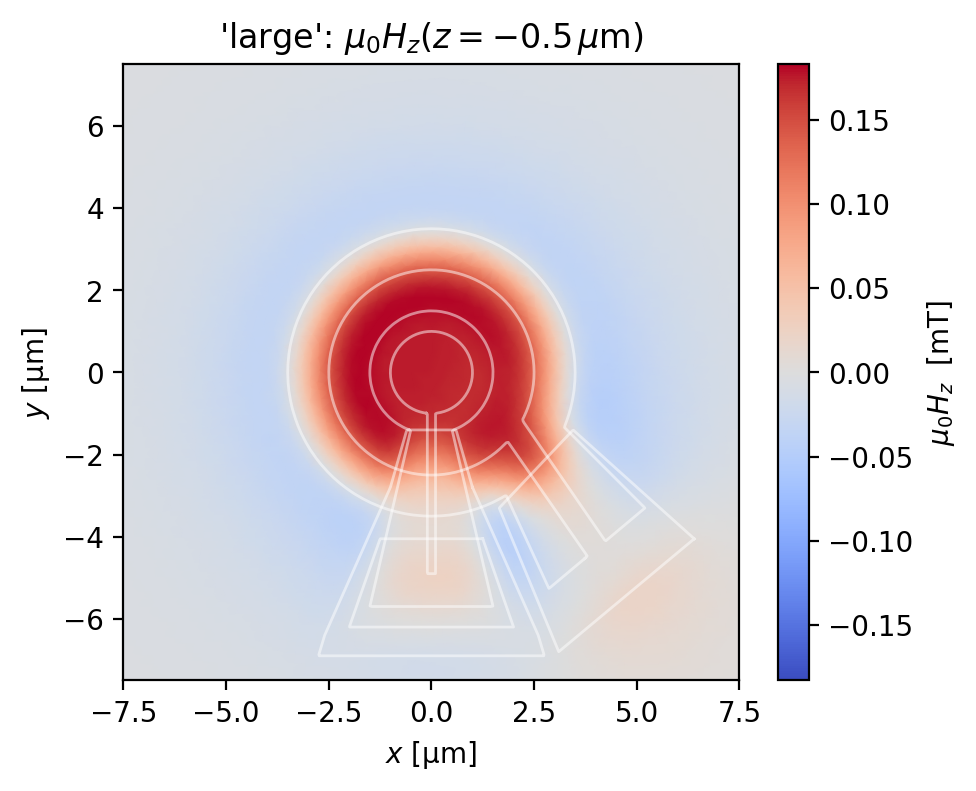

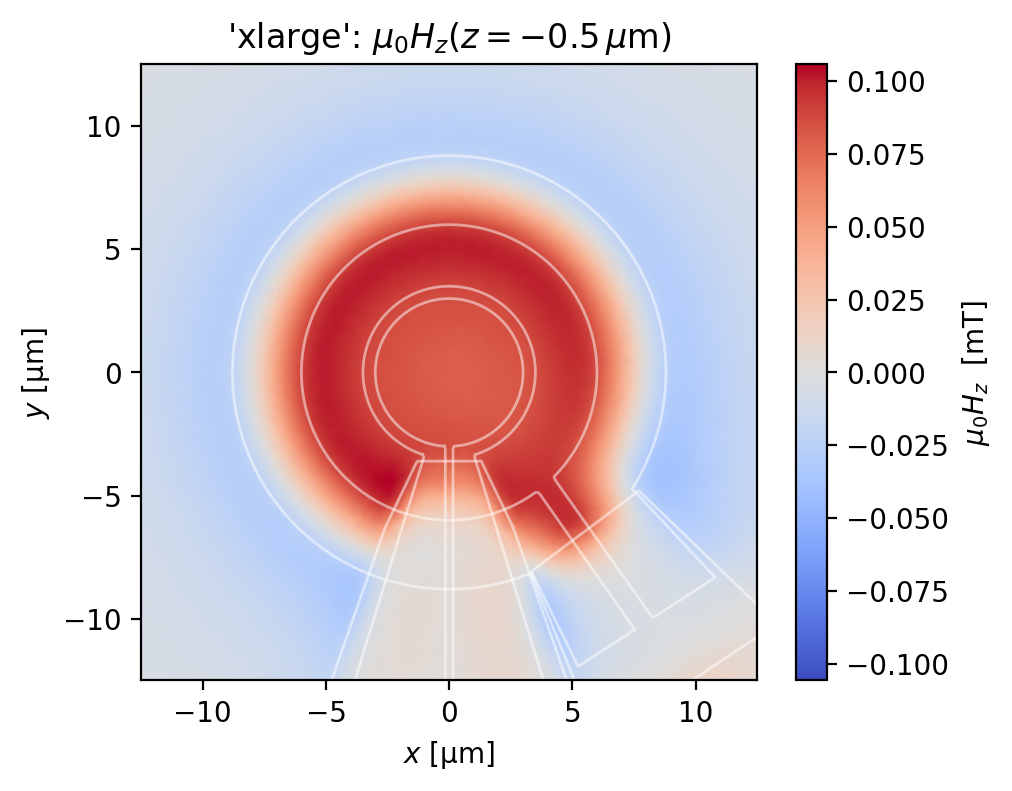

In [6]:
eval_regions = {
    # name: (width, height, z-position)
    "small": (5, 5, -0.5),
    "medium": (7.5, 7.5, -0.5),
    "large": (15, 15, -0.5),
    "xlarge": (25, 25, -0.5),
}
for name, solution in solutions.items():
    width, height, z = eval_regions[name]
    eval_mesh = sc.Polygon(points=box(width, height, points=201)).make_mesh(min_points=4000)
    fig, ax = solution.plot_field_at_positions(
        eval_mesh,
        zs=z,
        symmetric_color_scale=True,
        cmap="coolwarm",
    )
    squid = solution.device
    for polygon in squid.get_polygons(include_terminals=False):
        polygon.plot(ax=ax, color="w", lw=1, alpha=0.5)
    ax.set_title(rf"{name!r}: $\mu_0H_z(z={{{z}}}\,\mu\mathrm{{m}})$")

In [7]:
sc.version_table()

Software,Version
SuperScreen,0.9.0
Numpy,1.23.3
Numba,0.57.0
SciPy,1.9.1
matplotlib,3.6.0
IPython,8.5.0
Python,"3.9.13 | packaged by conda-forge | (main, May 27 2022, 17:01:00) [Clang 13.0.1 ]"
OS,posix [darwin]
Number of CPUs,"Physical: 10, Logical: 10"
BLAS Info,OPENBLAS
